In [18]:
import FINE as fn
import geopandas as gpd
import pandas as pd
import numpy as np
from os.path import dirname, abspath, join
import matplotlib.pyplot as plt
import os

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
#set paths
cwd = os.getcwd()
data_dir = join(cwd, "data")

path_to_regions = join(data_dir, "regions", "region_shape_NER.shp")

path_to_pv_ts = join(data_dir, "sources", "solar_ts_NER.csv")
path_to_onshore_ts = join(data_dir, "sources", "onshore_ts_NER.csv")

path_to_pv_cap = join(data_dir, "sources", "solar_cap_NER.csv")
path_to_onshore_cap = join(data_dir, "sources", "onshore_cap_NER.csv")

path_to_el_dem = join(data_dir, "sinks", "electricity_dem_NER.xlsx")
path_to_h2_dem = join(data_dir, "sinks", "hydrogen_dem_NER.xlsx")

path_to_transmission_shp = join(data_dir, "transmission", "transmissions_NER.shp")
path_to_incidence_matrix = join(data_dir, "transmission", "incidence_matrix_NER.csv")
path_to_distance_matrix = join(data_dir, "transmission", "euclidean_distance_matrix_NER.csv")

In [20]:
locations_shape = gpd.read_file(path_to_regions)
locations = locations_shape.GID_1.to_list() #will be ["NER.1_1", "NER.2_1", ... "NER.8_1"]

commodities = {"electricity", "hydrogen_gas"}
commodityUnitsDict = {
                "electricity": r"GW$_{el}$",
                "hydrogen_gas": r"GW$_{H_{2},LHV}$",
            }

In [21]:
#Set up esm Model

esM = fn.EnergySystemModel(
    locations=set(locations),
    commodities=commodities,
    numberOfTimeSteps=8760, #hours per year
    commodityUnitsDict=commodityUnitsDict,
    hoursPerTimeStep=1, #time step is one hour
    costUnit="1e9 Euro",
    lengthUnit="km",
    verboseLogLevel=0, #what is printed, just keep it
)


In [22]:
#add PV
pv_time_series=pd.read_csv(path_to_pv_ts, index_col=[0]).reset_index(drop=True) #capacity factor [1]
pv_capacity_max=pd.read_csv(path_to_pv_cap, index_col=[0])['capacity_kW'] / 1e6 #capacity [GW]

esM.add(
    fn.Source(
        esM=esM, 
        name="PV", 
        commodity="electricity", 
        hasCapacityVariable=True,
        operationRateMax=pv_time_series,
        capacityMax=pv_capacity_max,
        investPerCapacity=0.450, #1e9EUR/GW, 2030
        opexPerCapacity=0.017 * 0.450, #1e9EUR/a
        interestRate=0.08,  #1
        economicLifetime=20, #a
        ),
)


#add Wind Onshore
onshore_time_series=pd.read_csv(path_to_onshore_ts, index_col=[0]).reset_index(drop=True) #capacity factor [1]
onshore_capacity_max=pd.read_csv(path_to_onshore_cap, index_col=[0])['capacity_kW'] / 1e6 #capacity [GW]

esM.add(
    fn.Source(
        esM=esM, 
        name="Onshore", 
        commodity="electricity", 
        hasCapacityVariable=True,
        operationRateMax=onshore_time_series,
        capacityMax=onshore_capacity_max,
        investPerCapacity=1.130, #1e9EUR/GW, 2030
        opexPerCapacity=0.025 * 1.130, #1e9EUR/a
        interestRate=0.08, #1
        economicLifetime=20, #y
        ),
)

#add Demands
electricity_demand_operationRateFix=pd.read_excel(path_to_el_dem, index_col=[0], engine="openpyxl")*3 #elec demand GW

esM.add(
    fn.Sink(
        esM=esM, 
        name="electricity_demand", 
        commodity="electricity",
        hasCapacityVariable=False, 
        operationRateFix=electricity_demand_operationRateFix, #GW
    ),
)

#add Demands
hydrogen_demand_operationRateFix=pd.read_excel(path_to_h2_dem, index_col=[0], engine="openpyxl")*3 #elec demand GW

esM.add(
    fn.Sink(
        esM=esM, 
        name="hydrogen_demand", 
        commodity="hydrogen_gas",
        hasCapacityVariable=False, 
        operationRateFix=hydrogen_demand_operationRateFix, #GW
    ),
)

esM.add(
fn.Conversion(
    esM=esM,
    name="electrolyzer",
    physicalUnit=r"GW$_{el}$",
    commodityConversionFactors={"electricity": -1, "hydrogen_gas": 0.7},
    hasCapacityVariable=True,
    investPerCapacity=0.5,
    opexPerCapacity=0.5 * 0.025,
    interestRate=0.08,
    economicLifetime=10,
)
)

# add batteries
esM.add(
    fn.Storage(
        esM= esM,
        name= "Batteries", 
        commodity="electricity",
        hasCapacityVariable= True, 
        chargeEfficiency=0.95, #1
        dischargeEfficiency=0.95, #1
        cyclicLifetime=10000, #1
        selfDischarge=4.230E-05, #1
        chargeRate=1, #C-Rate: 1/h
        dischargeRate=1, #C-Rate: 1/h
        doPreciseTsaModeling= False,
        investPerCapacity=0.17511, #1e9EUR/GW, 2030
        opexPerCapacity= 0.02 * 0.17511, #1e9EUR/a
        interestRate=0.08, #1
        economicLifetime=20, #a
    ),
)

#add hydrogen storage
esM.add(
    fn.Storage(
        esM=esM,
        name=f"hydrogen_storage",
        commodity=f"hydrogen_gas",
        hasCapacityVariable=True,
        chargeEfficiency=1,
        cyclicLifetime=10000,
        dischargeEfficiency=1,
        selfDischarge=0, # 1% per day
        chargeRate=1,
        dischargeRate=1,
        doPreciseTsaModeling=False,
        investPerCapacity=0.0007, #0.70EUR/kWh = 0.0007 BEUR/GWh
        opexPerCapacity=0.02 * 0.0007,
        interestRate=0.08,
        economicLifetime=40,
    )
)


#### Task 1: Load the distance and incidence matrices

In [23]:
distance_matrix = pd.read_csv(path_to_distance_matrix, index_col=[0])
incidence_matrix = pd.read_csv(path_to_incidence_matrix, index_col=[0])

#### Task 2 (a) : Add hydrogen pipelines as a transmission component to the model

In [24]:
esM.add(
fn.Transmission(
    esM=esM,
    name="hydrogen_pipelines",
    commodity="hydrogen_gas",
    locationalEligibility=incidence_matrix,
    distances=distance_matrix,
    hasCapacityVariable=True,
    investPerCapacity=0.000177,
    investIfBuilt=0.00033,
    interestRate=0.08,
    economicLifetime=40,
    )
)

#### Task 2 (b) : Add electricity grid as a transmission component to the model

In [25]:
esM.add(
fn.Transmission(
    esM=esM,
    name="electricity_grid",
    commodity="electricity",
    locationalEligibility=incidence_matrix,
    distances=distance_matrix,
    hasCapacityVariable=True,
    investPerCapacity=0.0004,
    opexPerCapacity=1.35e-05,
    opexPerOperation=1.8e-05,
    losses=0.00001,
    interestRate=0.08,
    economicLifetime=40,
    )
)

In [26]:
# Temporal Aggregation
esM.aggregateTemporally(numberOfTypicalPeriods=7, 
                        segmentation=True,
                        numberOfSegmentsPerPeriod=8)


Clustering time series data with 30 typical periods and 24 time steps per period 
further clustered to 8 segments per period...
		(0.5377 sec)



In [27]:
#RUN the model:
print('Optimize')
esM.optimize(
    timeSeriesAggregation=True,
    optimizationSpecs="",
    solver="glpk"
)
print('Optimization done!')

Optimize
Time series aggregation specifications:
Number of typical periods:30, number of time steps per period:24, number of segments per period:8

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.7154 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.0308 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.4631 sec)

Declaring sets, variables and constraints for TransmissionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.5533 sec)

Declaring shared potential constraint...
		(0.0010 sec)

Declaring linked component quantity constraint...
		(0.0000 sec)

Declaring commodity balances...
		(0.3030 sec)

		(0.0000 sec)

Declaring objective function...
		(0.1396 sec)

GLPSOL--GLPK LP/MI

 c:\Users\a.burdack\Anaconda3\envs\GradSchoolESM\lib\site-packages\FINE\storage.py:1767: UserWarning:Charge and discharge at the same time for component Batteries
 c:\Users\a.burdack\Anaconda3\envs\GradSchoolESM\lib\site-packages\FINE\storage.py:1767: UserWarning:Charge and discharge at the same time for component hydrogen_storage


for StorageModel ...       (0.9021sec)
for TransmissionModel ...  (0.6575sec)
		(2.0628 sec)

Optimization done!


#### Task 3 (a) : Get the optimization summary of the TransmissionModel

In [28]:
esM.getOptimizationSummary("TransmissionModel", outputLevel=2)

NER.1_1  \
Component          Property  Unit                 LocationIn             
electricity_grid   TAC       [1e9 Euro/a]         NER.1_1          0.0   
                                                  NER.2_1     0.000002   
                                                  NER.3_1          0.0   
                                                  NER.4_1          0.0   
                                                  NER.5_1          0.0   
...                                                                ...   
hydrogen_pipelines operation [GW$_{H_{2},LHV}$*h] NER.4_1          0.0   
                                                  NER.5_1          NaN   
                                                  NER.6_1     0.100021   
                                                  NER.7_1          NaN   
                                                  NER.8_1     0.131804   

                                                               NER.2_1  \
Component          Property  Unit                 LocationIn             
electricity_grid   TAC       [1e9 Euro/a]         NER.1_1     0.000002   
                                                  NER.2_1          0.0   
                                                  NER.3_1          0.0   
                                                  NER.4_1          0.0   
                                                  NER.5_1          0.0   
...                                                                ...   
hydrogen_pipelines operation [GW$_{H_{2},LHV}$*h] NER.4_1          NaN   
                                                  NER.5_1          NaN   
                                                  NER.6_1          NaN   
                                                  NER.7_1          NaN   
                                                  NER.8_1     0.572352   

                                                                NER.3_1  \
Component          Property  Unit                 LocationIn              
electricity_grid   TAC       [1e9 Euro/a]         NER.1_1           0.0   
                                                  NER.2_1           0.0   
                                                  NER.3_1           0.0   
                                                  NER.4_1           0.0   
                                                  NER.5_1           0.0   
...                                                                 ...   
hydrogen_pipelines operation [GW$_{H_{2},LHV}$*h] NER.4_1           NaN   
                                                  NER.5_1           NaN   
                                                  NER.6_1     23.419039   
                                                  NER.7_1      0.019136   
                                                  NER.8_1           NaN   

                                                                NER.4_1  \
Component          Property  Unit                 LocationIn              
electricity_grid   TAC       [1e9 Euro/a]         NER.1_1           0.0   
                                                  NER.2_1           0.0   
                                                  NER.3_1           0.0   
                                                  NER.4_1           0.0   
                                                  NER.5_1           0.0   
...                                                                 ...   
hydrogen_pipelines operation [GW$_{H_{2},LHV}$*h] NER.4_1           NaN   
                                                  NER.5_1           NaN   
                                                  NER.6_1      1.779329   
                                                  NER.7_1           NaN   
                                                  NER.8_1     30.928816   

                                                               NER.5_1  \
Component          Property  Unit                 LocationIn             
electricity_grid   TAC       [1e9 Eur

#### Task 3 (b) : Display the total optimal capacity of the electricity grid and the hydrogen grid

In [29]:
esM.getOptimizationSummary("TransmissionModel", outputLevel=2).loc[('electricity_grid', 'capacity', '[GW$_{el}$]',)]

,NER.1_1,NER.2_1,NER.3_1,NER.4_1,NER.5_1,NER.6_1,NER.7_1,NER.8_1
LocationIn,,,,,,,,
NER.1_1,NaN,0.000101,NaN,0.0,NaN,0.00318,NaN,0.0
NER.2_1,0.000101,NaN,NaN,NaN,NaN,NaN,NaN,0.006654
NER.3_1,NaN,NaN,NaN,NaN,NaN,0.050531,0.022555,NaN
NER.4_1,0.0,NaN,NaN,NaN,NaN,0.105886,NaN,0.068382
NER.5_1,NaN,NaN,NaN,NaN,NaN,NaN,0.021482,NaN
NER.6_1,0.00318,NaN,0.050531,0.105886,NaN,NaN,0.044654,NaN
NER.7_1,NaN,NaN,0.022555,NaN,0.021482,0.044654,NaN,NaN
NER.8_1,0.0,0.006654,NaN,0.068382,NaN,NaN,NaN,NaN


In [30]:
esM.getOptimizationSummary("TransmissionModel", outputLevel=2).loc[('hydrogen_pipelines', 'capacity', '[GW$_{H_{2},LHV}$]',)]

,NER.1_1,NER.2_1,NER.3_1,NER.4_1,NER.5_1,NER.6_1,NER.7_1,NER.8_1
LocationIn,,,,,,,,
NER.1_1,NaN,0.000087,NaN,0.0,NaN,0.001008,NaN,0.000049
NER.2_1,0.000087,NaN,NaN,NaN,NaN,NaN,NaN,0.000722
NER.3_1,NaN,NaN,NaN,NaN,NaN,0.002676,0.000003,NaN
NER.4_1,0.0,NaN,NaN,NaN,NaN,0.003731,NaN,0.004207
NER.5_1,NaN,NaN,NaN,NaN,NaN,NaN,0.001352,NaN
NER.6_1,0.001008,NaN,0.002676,0.003731,NaN,NaN,0.003065,NaN
NER.7_1,NaN,NaN,0.000003,NaN,0.001352,0.003065,NaN,NaN
NER.8_1,0.000049,0.000722,NaN,0.004207,NaN,NaN,NaN,NaN


#### Task 3 (c) : Display the total annual cost (TAC) of the electricity grid and the hydrogen grid

In [31]:
esM.getOptimizationSummary("TransmissionModel", outputLevel=2).loc[('electricity_grid', 'TAC', '[1e9 Euro/a]',)]

,NER.1_1,NER.2_1,NER.3_1,NER.4_1,NER.5_1,NER.6_1,NER.7_1,NER.8_1
LocationIn,,,,,,,,
NER.1_1,0.0,0.000002,0.0,0.0,0.0,0.000094,0.0,0.0
NER.2_1,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.000083
NER.3_1,0.0,0.0,0.0,0.0,0.0,0.000523,0.000135,0.0
NER.4_1,0.0,0.0,0.0,0.0,0.0,0.001043,0.0,0.000703
NER.5_1,0.0,0.0,0.0,0.0,0.0,0.0,0.00005,0.0
NER.6_1,0.000069,0.0,0.000707,0.000994,0.0,0.0,0.000593,0.0
NER.7_1,0.0,0.0,0.000206,0.0,0.000152,0.00051,0.0,0.0
NER.8_1,0.0,0.000076,0.0,0.000728,0.0,0.0,0.0,0.0


In [32]:
esM.getOptimizationSummary("TransmissionModel", outputLevel=2).loc[('hydrogen_pipelines', 'TAC', '[1e9 Euro/a]',)]

,NER.1_1,NER.2_1,NER.3_1,NER.4_1,NER.5_1,NER.6_1,NER.7_1,NER.8_1
LocationIn,,,,,,,,
NER.1_1,0.0,0.0,0.0,0.0,0.0,0.000007,0.0,0.0
NER.2_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000002
NER.3_1,0.0,0.0,0.0,0.0,0.0,0.000009,0.0,0.0
NER.4_1,0.0,0.0,0.0,0.0,0.0,0.00001,0.0,0.000013
NER.5_1,0.0,0.0,0.0,0.0,0.0,0.0,0.000001,0.0
NER.6_1,0.000007,0.0,0.000009,0.00001,0.0,0.0,0.000011,0.0
NER.7_1,0.0,0.0,0.0,0.0,0.000001,0.000011,0.0,0.0
NER.8_1,0.0,0.000002,0.0,0.000013,0.0,0.0,0.0,0.0


#### Task 4 (a) : Plot the optimal capacities of the electricity grid

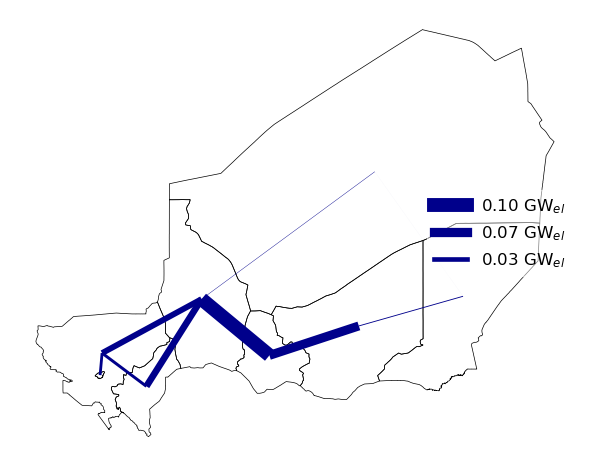

In [33]:
fig, ax = fn.plotLocations(path_to_regions, indexColumn="index", crs='epsg:3857')
fig, ax = fn.plotTransmission(
    esM, "electricity_grid", path_to_transmission_shp, loc0="bus_0", loc1="bus_1", fig=fig, ax=ax, crs='epsg:3857',
    linewidth=10, color='darkblue'
)

#### Task 4 (b) : Plot the optimal capacities of the hydrogen grid¶


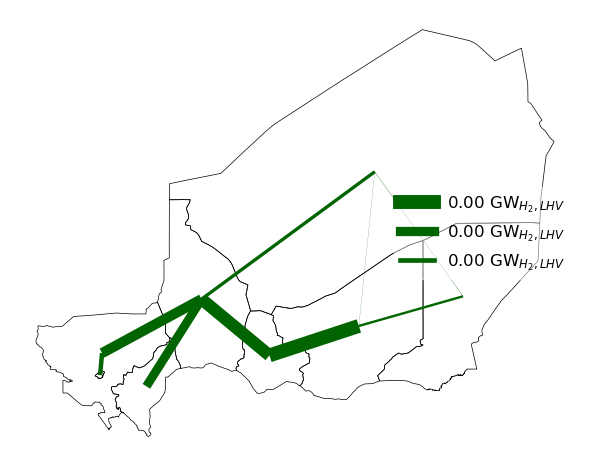

In [35]:
fig, ax = fn.plotLocations(path_to_regions, indexColumn="index", crs='epsg:3857')
fig, ax = fn.plotTransmission(
    esM, "hydrogen_pipelines", path_to_transmission_shp, loc0="bus_0", loc1="bus_1", fig=fig, ax=ax, crs='epsg:3857',
    linewidth=10, color='darkgreen'
)